# Reading from InfluxDB to Pandas

In [1]:
import pandas as pd
from influxdb import InfluxDBClient

In [2]:
host = 'localhost'
port = 8089 
user = 'root'
password = '8eVbA2uG4re0@&vzIeFyZ2'
dbname = 'intrusion'
measurement = 'traffic'

In [3]:
client = InfluxDBClient(
    host=host, 
    port=port, 
    username=user, 
    password=password, 
    database=dbname
)

In [4]:
query = f'SELECT * FROM {measurement} LIMIT 1000'

In [5]:
results = client.query(query)

In [6]:
points = list(results.get_points(measurement=measurement))

In [7]:
df = pd.DataFrame(points)

In [8]:
print('Data frame shape (rows, cols):', df.shape)

Data frame shape (rows, cols): (1000, 46)


In [9]:
print('Data frame column names: ', list(df.columns))

Data frame column names:  ['time', 'Attack Type', 'count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate', 'duration', 'flag', 'host', 'hot', 'iface', 'is_guest_login', 'is_host_login', 'land', 'logged_in', 'num_access_files', 'num_compromised', 'num_failed_logins', 'num_file_creations', 'num_outbound_cmds', 'num_root', 'num_shells', 'protocol_type', 'rerror_rate', 'root_shell', 'same_srv_rate', 'serror_rate', 'service', 'src_bytes', 'srv_count', 'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate', 'su_attempted', 'target', 'urgent', 'wrong_fragment']


# ML Step 1 : Data inspection

In [10]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df=pd.read_csv('data/dataFile.csv')
print(df.shape)
print(df.head())
print(df['target'].value_counts())
print(df['Attack Type'].value_counts())

(494021, 46)
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_diff_host_rate  \
0               0       0    0  ...                          0.0   
1               0       0    0  ...                          0.0   
2               0       0    0  ...                          0.0   
3               0       0    0  ...                          0.0   
4               0       0    0  ...                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   
1      

In [12]:
print("Colonnes disponibles :", df.columns.tolist())

Colonnes disponibles : ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target', 'Attack Type', 'measurement_name', 'iface', 'time']


In [13]:
def bar_graph(feature,ax=None):
    df[feature].value_counts().plot(kind='bar',ax=ax, title=feature)

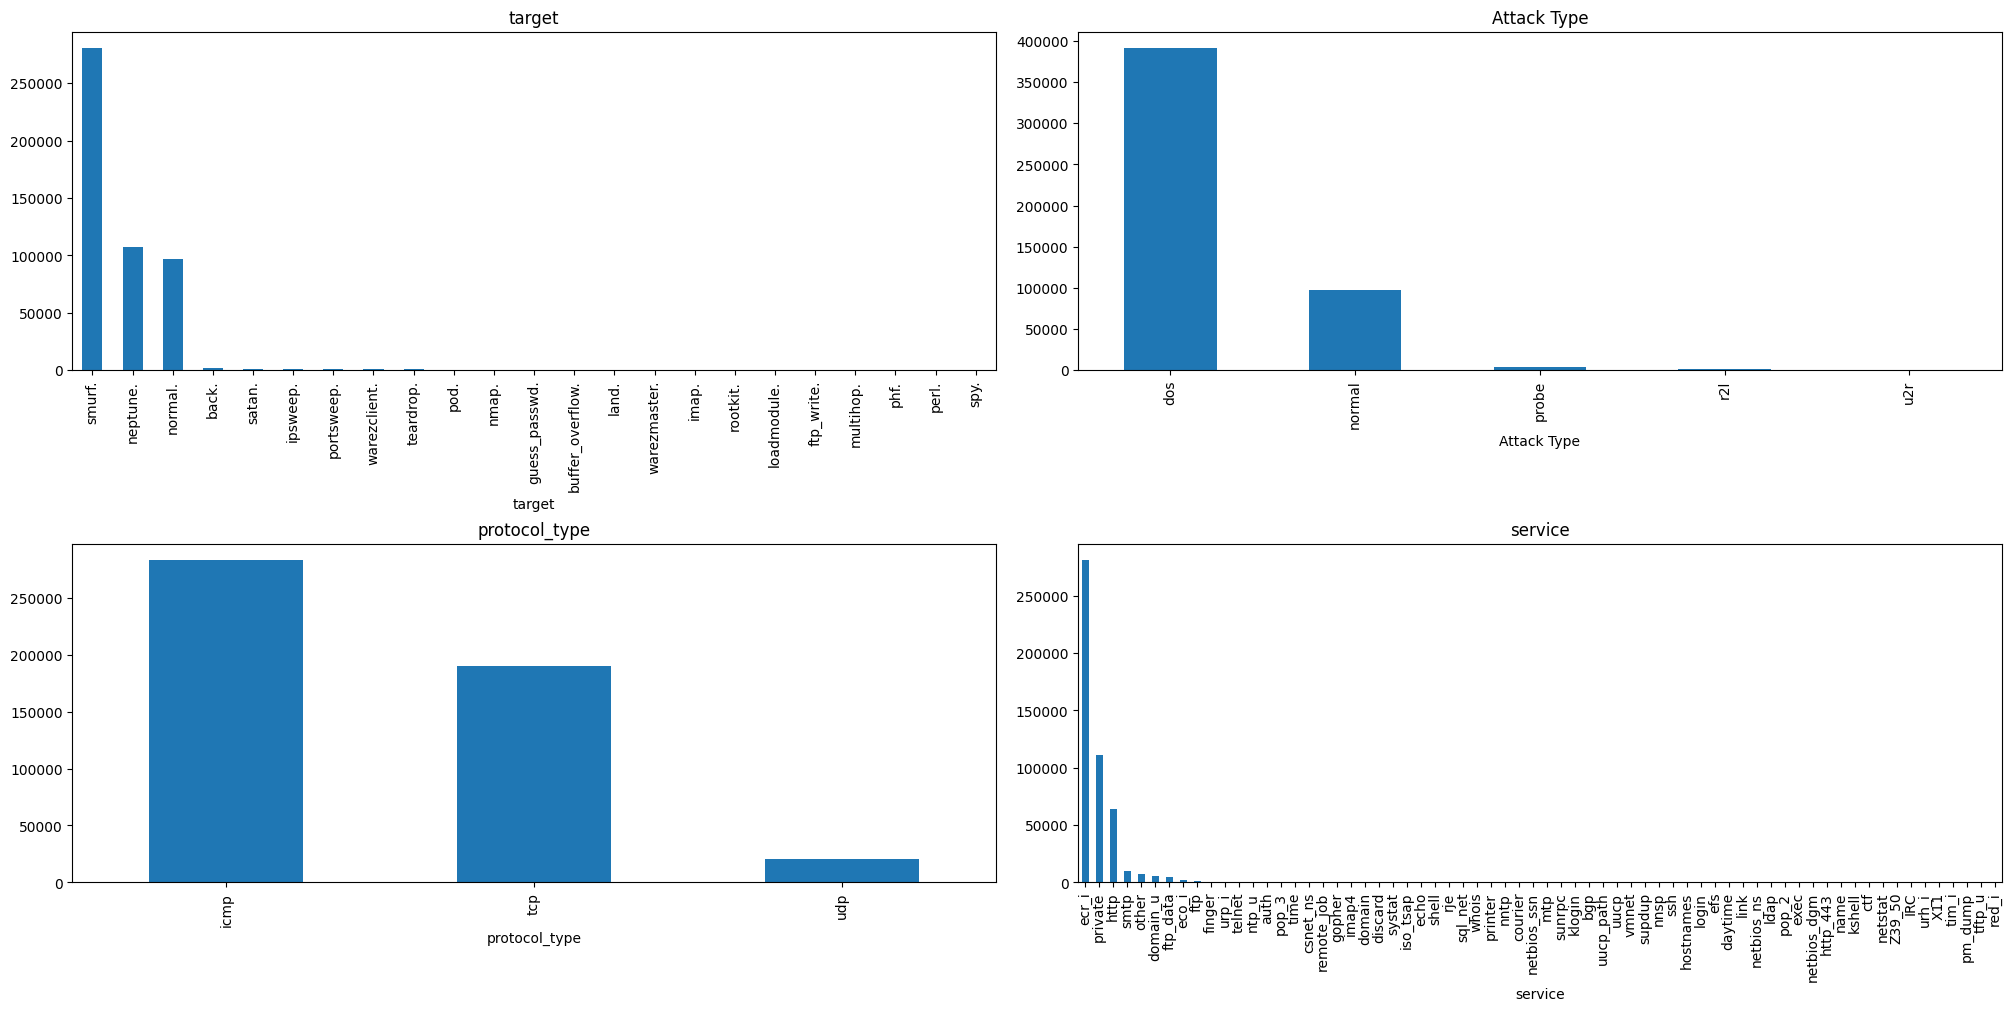

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,
10),constrained_layout=True)
bar_graph('target',ax=ax1)
bar_graph('Attack Type', ax=ax2)
bar_graph('protocol_type', ax=ax3)
bar_graph('service', ax=ax4)
plt.show()

There are mainly smurf target, DDoS attack, ICMP protocol attacks, targeting the ecr_i service.

# ML Step 2 : Feature transformation and cleaning

In [15]:
print('Data types before transformation')
print(df.dtypes)

Data types before transformation
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    

In [16]:
pmap = {'icmp':0,'tcp':1,'udp':2}
df['protocol_type'] = df['protocol_type'].map(pmap)

In [17]:
fmap = {'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5 ,'S1':6,'S2':7,'RSTOS0':8,'S3':9 ,'OTH':10}
df['flag'] = df['flag'].map(fmap)

In [18]:
df.drop('service',axis = 1,inplace= True)
df.drop(['target',], axis=1, inplace= True)
df = df.dropna(axis=1)
df = df[[col for col in df if df[col].nunique() > 1]]

In [19]:
print('Data types after transformation')
print(df.dtypes)

Data types after transformation
duration                         int64
protocol_type                    int64
flag                             int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate                float64
rerror_rate                    float64
srv_rerror_rate                f

# ML Step 3 : Feature Selection 

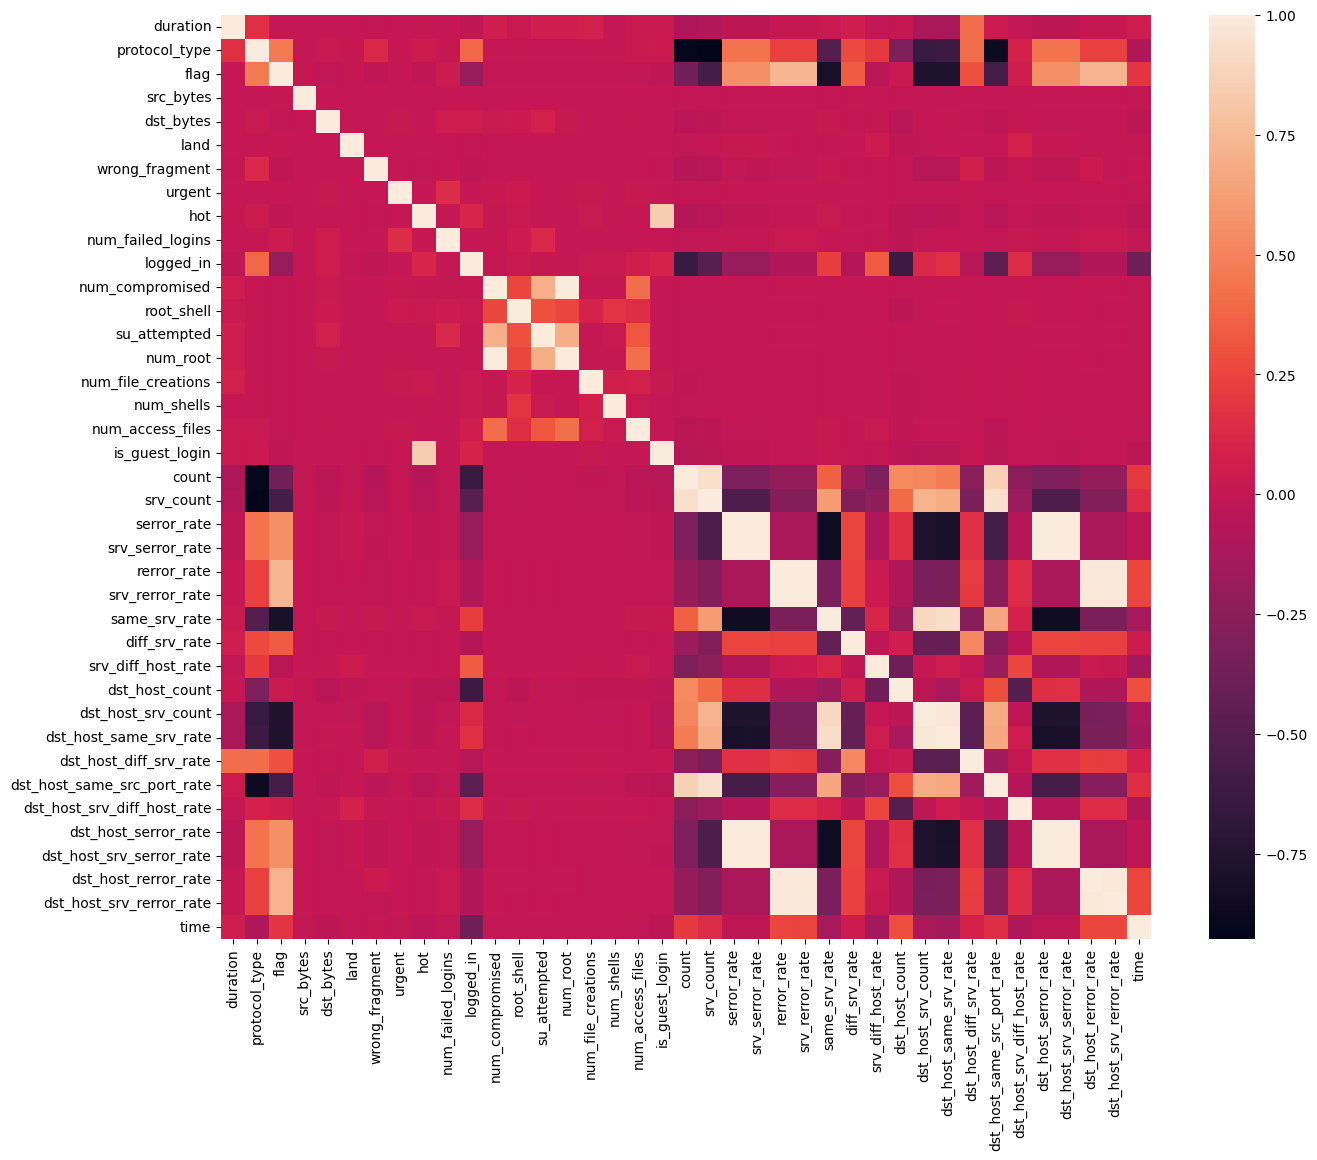

In [20]:
corr = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

In [21]:
cor_thr=0.98

print('Shape before feature reduction: ', df.shape)
corr_matrix = df.select_dtypes(include=['number']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > cor_thr)]

print('Features that need to be dropped')
print(to_drop)

for i in to_drop:
    df.drop(i,axis = 1,inplace = True)

print('Shape after feature reduction: ', df.shape)

Shape before feature reduction:  (494021, 40)
Features that need to be dropped
['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
Shape after feature reduction:  (494021, 33)


# ML Step 4 : Data sets preparation

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Target variable and train set
Y = df[['Attack Type']]
X = df.drop(['Attack Type',], axis=1)

In [24]:
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [25]:
# Split test and train data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(330994, 32) (163027, 32)
(330994, 1) (163027, 1)


# ML Step 5.1 : Model training (Decision Tree)

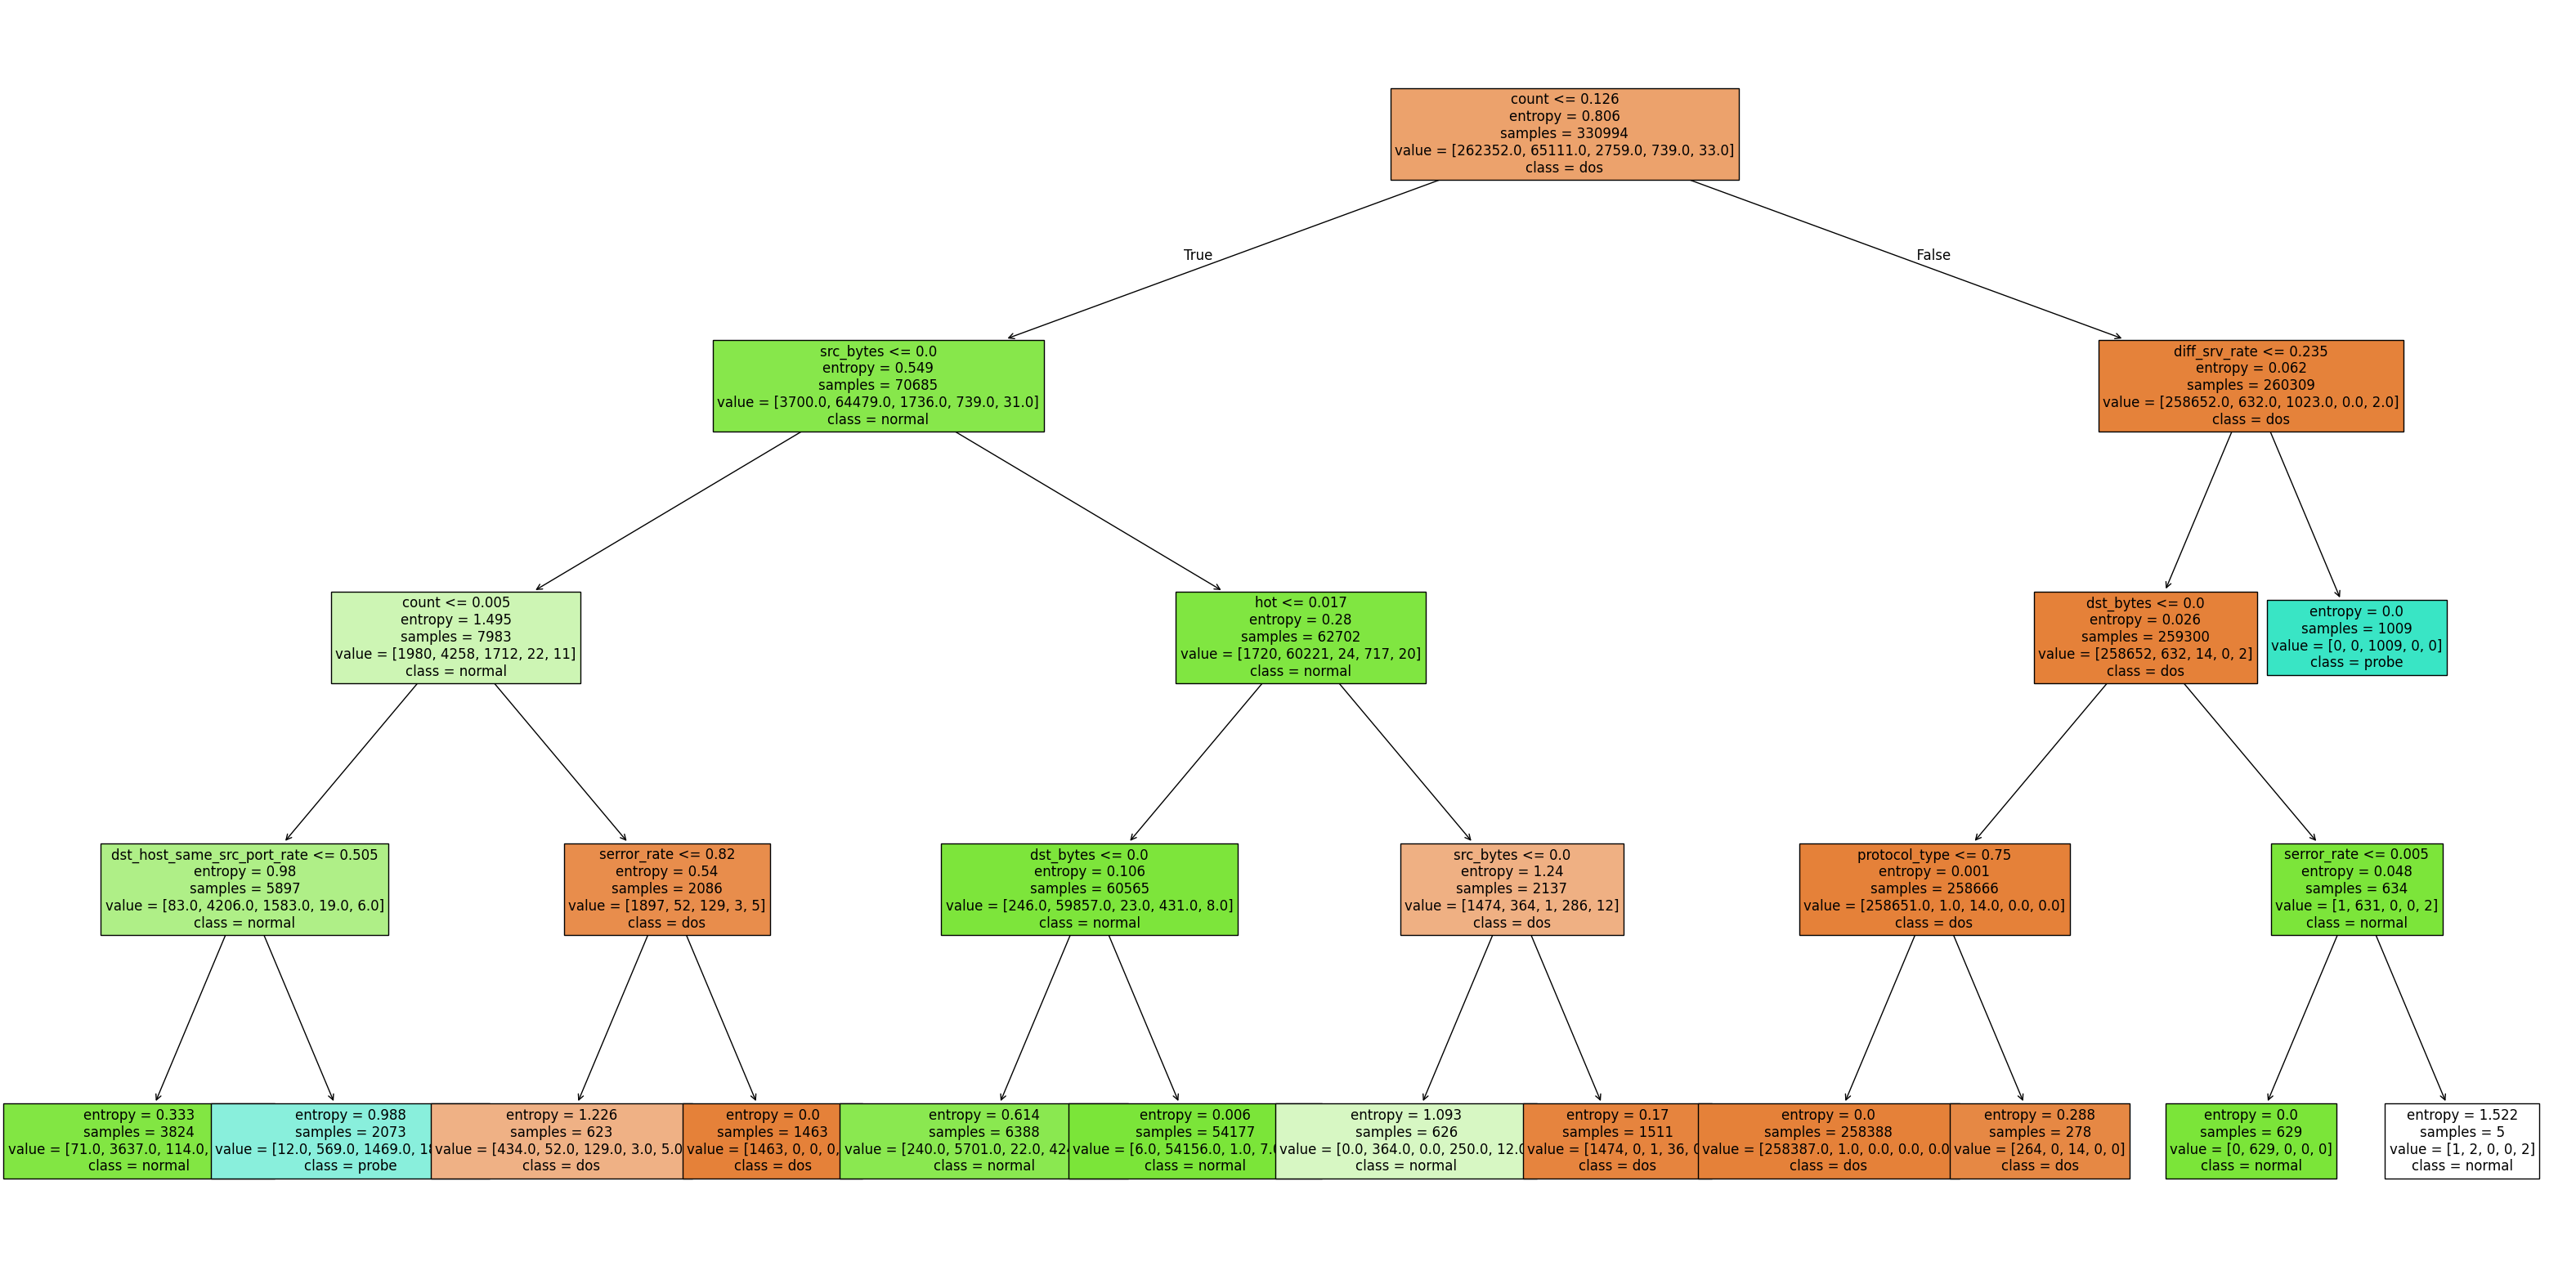

In [26]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(criterion='entropy', max_depth = 4)

start_time = time.time()
model_dt.fit(X_train, Y_train.values.ravel())
time_train_tree = time.time() - start_time

fig = plt.figure(figsize=(40,20))
_ = tree.plot_tree(model_dt, feature_names=df.columns, class_names=model_dt.classes_,filled=True, fontsize=12)

# ML Step 5.2 : Model training (Support Vector Machine)

In [45]:
from sklearn.svm import SVC

model_svm = SVC(kernel='linear', gamma = 'scale')
start_time = time.time()
model_svm.fit(X_train, Y_train.values.ravel())
time_train_svm = time.time() - start_time
print(time_train_svm)

147.96981287002563


2 minutes to train the SVM model.

# ML Step 5.3 : ML training (ANN)

In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('ERROR') 

In [33]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping

In [34]:
# Encode Y_train into Numeric Labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train) # Convert categorical labels to integers
num_classes = len(np.unique(Y_train_encoded)) # Determine number of classes
Y_train_onehot = to_categorical(Y_train_encoded, num_classes=num_classes)

/home/wolfy/lucie/code/github/AI/AttacksDetector/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
def ann():
    model = Sequential()
    model.add(Dense(30, input_dim=32, activation='relu', kernel_initializer='random_uniform'))
    model.add(Dense(10, activation='relu')) # Added hidden layer for better learning
    model.add(Dense(num_classes, activation='softmax')) # Ensure correct output shape
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
model_ann = KerasClassifier(build_fn=ann, epochs=50, batch_size=64, verbose=1)
start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [37]:
model_ann.fit(X_train, Y_train_onehot, callbacks=[callback])
time_train_ann = time.time() - start_time
print(time_train_ann)

/home/wolfy/lucie/code/github/AI/AttacksDetector/venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/wolfy/lucie/code/github/AI/AttacksDetector/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-10 02:01:37.234485: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50


2025-04-10 02:01:37.471628: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42367232 exceeds 10% of free system memory.


5172/5172 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9625 - loss: 0.1640
Epoch 2/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9970 - loss: 0.0112
Epoch 3/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9985 - loss: 0.0066
Epoch 4/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9986 - loss: 0.0055
Epoch 5/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9987 - loss: 0.0048
Epoch 6/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9988 - loss: 0.0044
Epoch 7/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9988 - loss: 0.0042
Epoch 8/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9990 - loss: 0.0039
Epoch 9/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9990 - loss: 0.0038
Epoch 10/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9990 - loss: 0.0034
Epoch 11/50
5172/5172 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9990 - loss: 0.0035
Epoch 12/50
5172/5172 ━━━━━━━━━━━━━━

# ML Step 6 : Model evaluation

In [40]:
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(Y_real, Y_pred, title=None):
    labels=np.unique(Y_real)
    nc=len(labels)
    data=np.zeros((nc,nc))
    pairs=zip(Y_real,Y_pred)
    pairs=list(pairs)
    for p in pairs: data[np.where(labels==p[0]),np.where(labels==p[1])]+=1
    row_total=np.sum(data,axis=1)
    data=data/row_total.reshape((nc,1))
    sns.set_theme(color_codes=True)
    plt.figure(1, figsize=(9, 6))
    plt.title('Confusion Matrix') if title is None else plt.title(title)
    sns.set_theme(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap='Blues', cbar_kws={'label': 'Scale'})
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set(ylabel='True Label', xlabel='Predicted Label')
    plt.show()

## Evaluate DT

In [41]:
print('DT evaluation')
start_time = time.time()
Y_train_pred=model_dt.predict(X_train)
Y_test_pred=model_dt.predict(X_test)
time_eval_tree=time.time()-start_time
print('Overall accuracy training: ', accuracy_score(Y_train,Y_train_pred))
print('Overall accuracy test: ', accuracy_score(Y_test,Y_test_pred))

DT evaluation
Overall accuracy training:  0.9939424883834752
Overall accuracy test:  0.9938476448686414


In [42]:
print('Training time (seconds per sample): ', time_train_tree/float(Y_train.shape[0]))
print('Evaluation time (seconds per sample): ',
time_eval_tree/(float(Y_train.shape[0])+float(Y_test.shape[0])))

Training time (seconds per sample):  4.229905345327153e-06
Evaluation time (seconds per sample):  5.888259053655705e-07


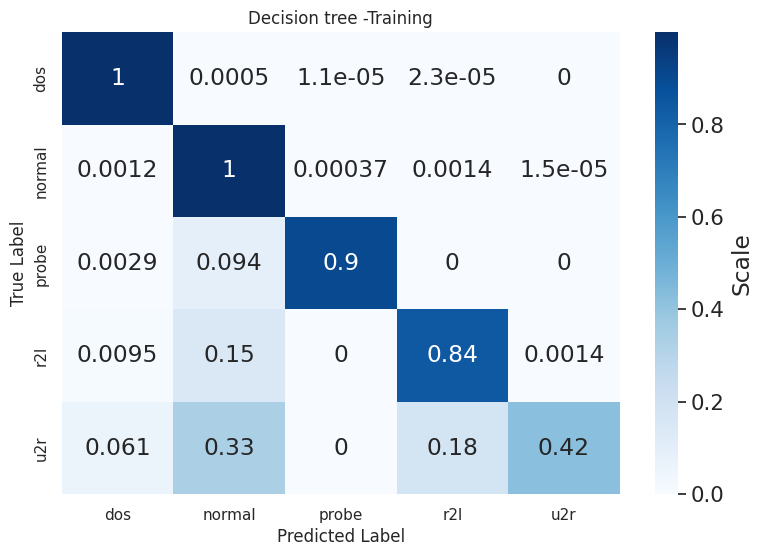

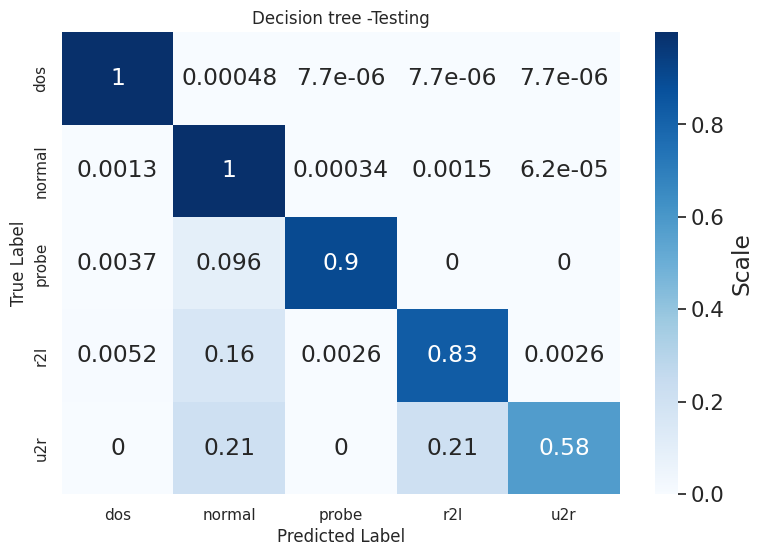

In [49]:
plot_confusion_matrix(Y_train.values.ravel(),Y_train_pred, title='Decision tree -Training')
plot_confusion_matrix(Y_test.values.ravel(),Y_test_pred, title='Decision tree -Testing')

## Evaluate SVM

In [46]:
print('SVM evaluation')
start_time = time.time()
Y_train_pred=model_svm.predict(X_train)
Y_test_pred=model_svm.predict(X_test)
time_eval_svm=time.time()-start_time

SVM evaluation


In [47]:
print('Overall accuracy training: ', accuracy_score(Y_train,Y_train_pred))
print('Overall accuracy test: ', accuracy_score(Y_test,Y_test_pred))

Overall accuracy training:  0.9977824371438757
Overall accuracy test:  0.9976936335698995


Training time (seconds per sample):  0.0004470468131447266
Evaluation time (seconds per sample):  7.78257721716103e-05


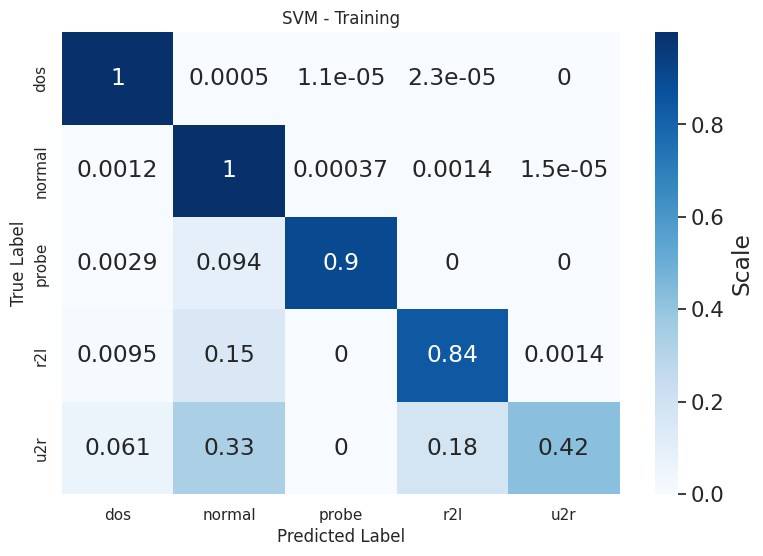

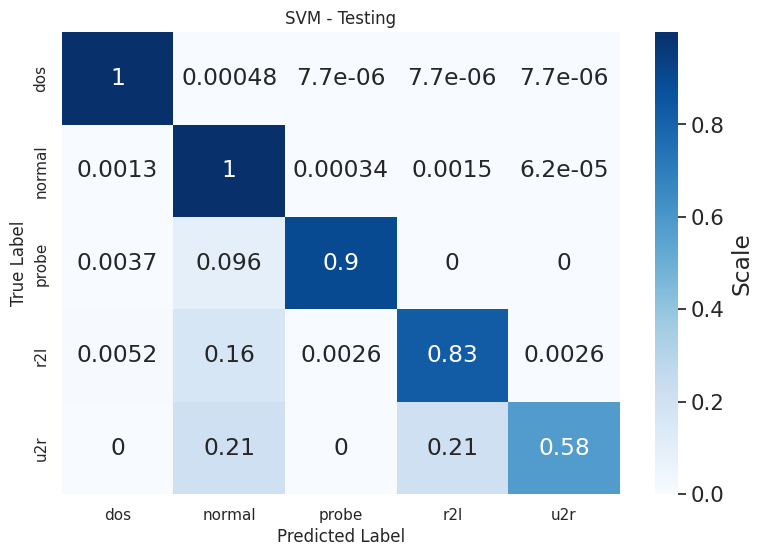

In [48]:
print('Training time (seconds per sample): ', time_train_svm/float(Y_train.shape[0]))
print('Evaluation time (seconds per sample): ',
time_eval_svm/(float(Y_train.shape[0])+float(Y_test.shape[0])))

plot_confusion_matrix(Y_train.values.ravel(),Y_train_pred, title='SVM - Training')
plot_confusion_matrix(Y_test.values.ravel(),Y_test_pred, title='SVM - Testing')

## Evaluate ANN

In [50]:
from sklearn.metrics import accuracy_score
print('ANN evaluation')
start_time = time.time()
Y_train_pred_proba = model_ann.predict(X_train)
Y_test_pred_proba = model_ann.predict(X_test)
Y_train_pred_classes = np.argmax(Y_train_pred_proba, axis=1)
Y_test_pred_classes = np.argmax(Y_test_pred_proba, axis=1)

ANN evaluation
   1/5172 ━━━━━━━━━━━━━━━━━━━━ 11:29 133ms/step

2025-04-10 02:24:05.216265: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42367232 exceeds 10% of free system memory.


5172/5172 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 2s 620us/step


In [51]:
Y_train_pred_labels = label_encoder.inverse_transform(Y_train_pred_classes)
Y_test_pred_labels = label_encoder.inverse_transform(Y_test_pred_classes)
time_eval_ann = time.time() - start_time

In [52]:
Y_train_encoded = label_encoder.transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

/home/wolfy/lucie/code/github/AI/AttacksDetector/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/wolfy/lucie/code/github/AI/AttacksDetector/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [53]:
print('Overall accuracy training: ', accuracy_score(Y_train_encoded, Y_train_pred_classes))
print('Overall accuracy test: ', accuracy_score(Y_test_encoded, Y_test_pred_classes))
print('Training time (seconds per sample): ', time_train_ann / float(Y_train.shape[0]))
print('Evaluation time (seconds per sample): ', time_eval_ann / (float(Y_train.shape[0]) +
float(Y_test.shape[0])))

Overall accuracy training:  0.9995709892022212
Overall accuracy test:  0.9993436669999448
Training time (seconds per sample):  0.0013947847868441552
Evaluation time (seconds per sample):  4.1637108677060536e-05


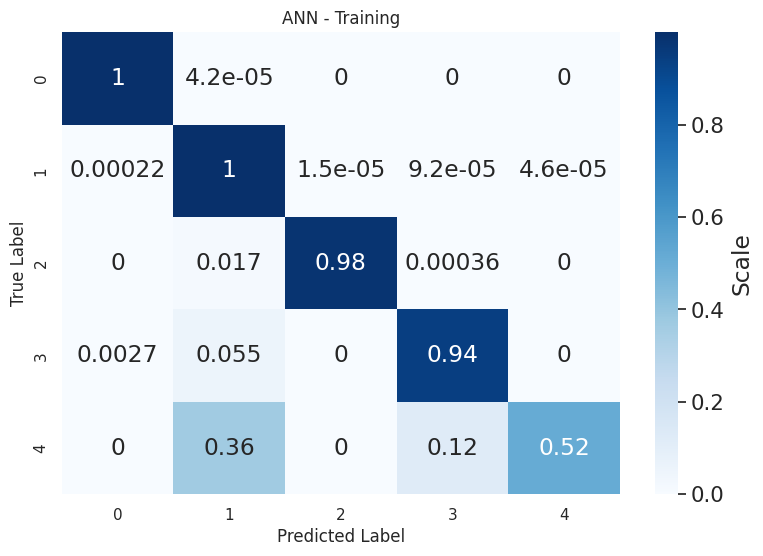

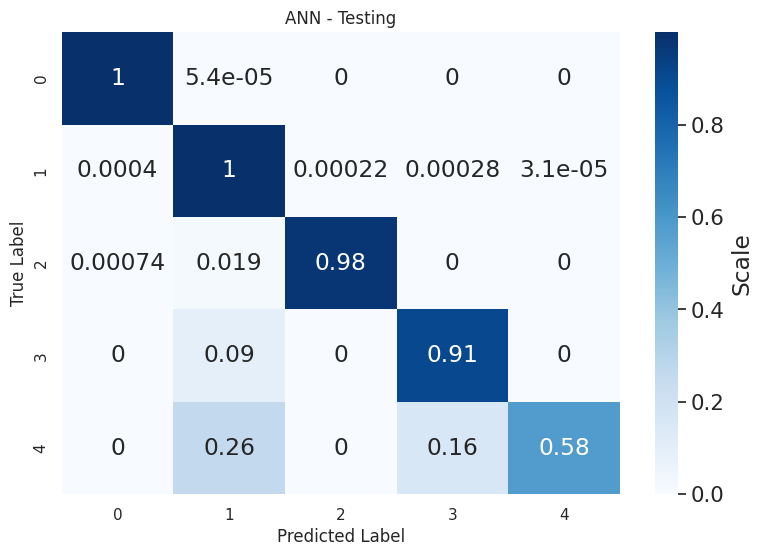

In [54]:
plot_confusion_matrix(Y_train_encoded, Y_train_pred_classes, title='ANN - Training')
plot_confusion_matrix(Y_test_encoded, Y_test_pred_classes, title='ANN - Testing')

# ML Step 8 : Save the models

In [74]:
import joblib
 
joblib.dump(sc, 'scaler.joblib')

joblib.dump(model_dt, 'model_dt.joblib')
joblib.dump(model_svm, 'model_svm.joblib')
joblib.dump(model_ann, 'model_ann.joblib')

label_encoder = LabelEncoder()
label_encoder.fit(Y_train)
joblib.dump(label_encoder, 'label_encoder.joblib')


/home/wolfy/lucie/code/github/AI/AttacksDetector/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['label_encoder.joblib']

In [73]:
scaler = joblib.load('scaler.joblib')
model_dt = joblib.load('model_dt.joblib')            
model_svm = joblib.load('model_svm.joblib')          
model_ann = joblib.load('model_ann.joblib')   

X_test_samples = X_test[700:1750]        
X_test_samples_normalized = scaler.transform(X_test_samples) 

# ANN Prediction
Y_test_pred_ann = model_ann.predict(X_test_samples_normalized)
 
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)                           
Y_test_pred_labels = np.argmax(Y_test_pred_ann, axis=1)  
Y_test_pred_final = label_encoder.inverse_transform(Y_test_pred_labels)  
 
print("Prédictions du modèle ANN original :")
print(Y_test_pred_ann) 

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

/home/wolfy/lucie/code/github/AI/AttacksDetector/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Prédictions du modèle ANN original :
[[0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]


/home/wolfy/lucie/code/github/AI/AttacksDetector/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
